In [1]:
import fiona
import geopandas as gpd
import pandas as pd
import shapely
from shapely import geometry
import json
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
import googlemaps
import time
from IPython.core.display import display, HTML
from IPython.display import IFrame
import re
from multiprocessing.dummy import Pool
from multiprocessing import cpu_count, freeze_support
from functools import partial
import ast 

In [2]:
#логер
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
    
    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [3]:
def getDataFromPage(url, driver):
#     print(url, driver)
    driver.get(url)
    time.sleep(4)
    
    ret_obj = {}
    
    ret_obj['url'] = url
    
    #title
    try:
        ret_obj['title'] = driver.find_element_by_css_selector('h1[class="x3AX1-LfntMc-header-title-title gm2-headline-5"] span').text
    except:
        ret_obj['title'] = ""
        
    #address
    try:
        ret_obj['address'] = driver.find_element_by_css_selector('div[class="QSFF4-text gm2-body-2"]').text
    except:
        ret_obj['address'] = ""
    
#     #rating
#     try:
#         ret_obj['rating'] = float(driver.find_element_by_css_selector('span.section-star-display').text.replace(',','.'))
#     except:
#         ret_obj['rating'] = 0
    
#     #review
#     try:
#         review_button = driver.find_element_by_css_selector('button.widget-pane-link[jsaction="pane.rating.moreReviews"]')
#         ret_obj['review_counts'] = int(re.search(r'\d+', review_button.text.replace(' ', ''))[0])
#     except:
#         ret_obj['review_counts'] = 0
        
    #category
    try:
        category_element = driver.find_element_by_css_selector('div[class="gm2-body-2"]')
        ret_obj['category'] = category_element.text
    except:
        try:
            category_element = driver.find_element_by_css_selector('h2[class="x3AX1-LfntMc-header-title-VdSJob"]') 
            ret_obj['category'] = category_element.text
        except:
            ret_obj['category'] = ""
    
    #review histogram
    try:
        hist = driver.find_elements_by_xpath('.//tr[contains(@class, "__histogram")]')
        if len(hist) == 5:
            reviews_hist = {
                "5": int(re.match(r'\d+', hist[0].get_attribute("aria-label").split(',')[1]).group(0)),
                "4": int(re.match(r'\d+', hist[1].get_attribute("aria-label").split(',')[1]).group(0)),
                "3": int(re.match(r'\d+', hist[2].get_attribute("aria-label").split(',')[1]).group(0)),
                "2": int(re.match(r'\d+', hist[3].get_attribute("aria-label").split(',')[1]).group(0)),
                "1": int(re.match(r'\d+', hist[4].get_attribute("aria-label").split(',')[1]).group(0)),
            }
            
            ret_obj['review_hist'] = reviews_hist
    except:
        ret_obj['reviews_hist'] = {}
    
    #popular times
    try:
        popular_times_days_sections = driver.find_elements_by_css_selector('div[class="O9Q0Ff-NmME3c-Utye1-haAclf"]')
    
#         counter = 0
#         days = ['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Cуббота']
#         poptimes = {}
        for day in popular_times_days_sections:
            ret_obj['popular_times_bars'] = [e.get_attribute("aria-label") for e in day.find_elements_by_css_selector('div.O9Q0Ff-NmME3c-Utye1-ZMv3u')]
#             poptimes[days[counter]] = pop_times_bars
#             counter+=1
#         ret_obj['popular_times_bars'] = pop_times_bars
           
    except Exception as e:
        ret_obj['popular_times_bars'] = {}
    
        
    return ret_obj

In [4]:
def google_scraping_func(url_list):
    driver = webdriver.Chrome('chromedriver.exe')
    
    for url in log_progress(url_list, 1):
        place = getDataFromPage(url, driver)
        places.append(place)
    
    return places

In [263]:
df = pd.read_csv('../data/raw_data.csv')

In [37]:
df.head()

,business_status,geometry,icon,icon_background_color,icon_mask_base_uri,name,photos,place_id,plus_code,rating,reference,scope,types,user_ratings_total,vicinity,opening_hours,price_level,lat,lon,url
0,OPERATIONAL,POINT (39.0925118 45.0370921),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Сквер «Субботний»,"[{'height': 2250, 'html_attributions': ['<a hr...",ChIJ1wuQEOda8EARP7B99phyQNc,"{'compound_code': '23PV+R2 Krasnodar', 'global...",3.7,ChIJ1wuQEOda8EARP7B99phyQNc,GOOGLE,"['park', 'point_of_interest', 'establishment']",3,"Ulitsa Ural'skaya, 158, Krasnodar",NaN,NaN,45.037092,39.092512,https://www.google.com/maps/place/?q=place_id:...
1,OPERATIONAL,POINT (39.097586 45.0420204),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Сквер «Субботний»,NaN,ChIJ1wuQEOda8EARJS-lBjJCrCI,"{'compound_code': '23RX+R2 Krasnodar', 'global...",0.0,ChIJ1wuQEOda8EARJS-lBjJCrCI,GOOGLE,"['park', 'point_of_interest', 'establishment']",0,"Ulitsa Ural'skaya, 158, Krasnodar",NaN,NaN,45.042020,39.097586,https://www.google.com/maps/place/?q=place_id:...
2,OPERATIONAL,POINT (39.0955591 45.0224408),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Skver,"[{'height': 4320, 'html_attributions': ['<a hr...",ChIJ1-XXYIla8EAR6qWh11NYY8A,"{'compound_code': '23CW+X6 Krasnodar', 'global...",4.4,ChIJ1-XXYIla8EAR6qWh11NYY8A,GOOGLE,"['park', 'point_of_interest', 'establishment']",666,"к, Ulitsa Kirova, 183к2, Krasnodar",{'open_now': True},NaN,45.022441,39.095559,https://www.google.com/maps/place/?q=place_id:...
3,OPERATIONAL,POINT (39.0382741 45.07198229999999),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Skver Serdtse Gubernskogo,NaN,ChIJr4MvRudF8EARPAAyBpE8PcU,"{'compound_code': '32CQ+Q8 Krasnodar', 'global...",5.0,ChIJr4MvRudF8EARPAAyBpE8PcU,GOOGLE,"['park', 'point_of_interest', 'establishment']",5,"Ulitsa Dombayskaya, 15, Krasnodar",NaN,NaN,45.071982,39.038274,https://www.google.com/maps/place/?q=place_id:...
4,OPERATIONAL,POINT (39.1035563 45.0129496),https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Ботанический сад 1/ КубГУ,NaN,ChIJj1KR7K5b8EAR2sEDSquYAtU,"{'compound_code': '2473+5C Krasnodar', 'global...",4.0,ChIJj1KR7K5b8EAR2sEDSquYAtU,GOOGLE,"['university', 'point_of_interest', 'establish...",2,"Ulitsa Gogolya, 92, Krasnodar",NaN,NaN,45.012950,39.103556,https://www.google.com/maps/place/?q=place_id:...


Места с наличием отзывов (рейтинга)

In [56]:
df.loc[(~df.rating.isna())].shape[0]

(8329, 21)

In [81]:
set(df['types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().keys()) - \
set(df.loc[(~df.rating.isna()), 'types'].apply(lambda s: list(ast.literal_eval(s))).explode().value_counts().keys())

{'locality',
 'neighborhood',
 'political',
 'sublocality',
 'sublocality_level_1',
 'sublocality_level_2'}

In [213]:
places_df = pd.read_csv('../data/places_GP_temp.csv')

In [264]:
places = []

In [265]:
datalist = df.loc[~df.url.isin(places_df.url), 'url']

if __name__== "__main__":
    freeze_support()
    pool = Pool()

    # max number of parallel process
    ITERATION_COUNT = cpu_count()-1 if len(datalist) >= cpu_count()-1 else len(datalist)

    count_per_iteration = len(datalist) / float(ITERATION_COUNT)

    for i in range(0, ITERATION_COUNT):
        list_start = int(count_per_iteration * i)
        list_end = int(count_per_iteration * (i+1))
        pool.apply_async(google_scraping_func, [datalist[list_start:list_end]])

In [266]:
df_p = pd.DataFrame(places)
df_p.shape

(802, 5)

## Проверка сколько осталось

In [336]:
df_p = pd.DataFrame(places)
size = df_p.shape[0]
end = 0
for i in range(0,60):
    df_p = pd.DataFrame(places)
    end = df_p.shape[0]
    time.sleep(1)
end-size

43

In [365]:
len(df.loc[~df.url.isin(df_p.url)]),len(df.loc[~df.url.isin(gdf.url)])/(end-size)

(96, 4.1395348837209305)

## Создание датасета

In [267]:
gdf = gpd.GeoDataFrame(df_p.merge(df[['url', 'geometry', 'types', 'rating', 'user_ratings_total']]))

In [268]:
gdf.geometry = [shapely.wkt.loads(r['geometry']) for i, r in gdf.iterrows()]

In [269]:
gdf.drop_duplicates('url', inplace = True)

In [262]:
places_df.to_csv('../data/places_GP_temp.csv', index = False)

In [14]:
gdf.drop(columns = 'reviews_hist', inplace = True)

KeyError: "['reviews_hist'] not found in axis"

In [85]:
gdf

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total
0,https://www.google.com/maps/place/?q=place_id:...,,Об этих данных,,NaN,None,NaN,NaN,NaN
1,https://www.google.com/maps/place/?q=place_id:...,"Новый век, СФ","ул. Демуса, 60, Краснодар, Краснодарский край,...",Строительная компания,NaN,None,NaN,NaN,NaN
2,https://www.google.com/maps/place/?q=place_id:...,Магазин автоприцепов,"ул. Ростовское ш., 24/1, Краснодар, Краснодарс...",Продажа прицепов,NaN,None,NaN,NaN,NaN
3,https://www.google.com/maps/place/?q=place_id:...,Pepe магазин детской одежды,"Краснодар, Краснодарский край, 350901",Магазин одежды,NaN,None,NaN,NaN,NaN
4,https://www.google.com/maps/place/?q=place_id:...,Трейд Инвест,"ул. Тихорецкая, 8, Краснодар, Краснодарский кр...",Оптовая продажа строительных материалов,NaN,None,NaN,NaN,NaN
5,https://www.google.com/maps/place/?q=place_id:...,Первый Риэлт Центр,"Краснодар, Краснодарский край, 350000",Агентство недвижимости,NaN,None,NaN,NaN,NaN
6,https://www.google.com/maps/place/?q=place_id:...,ТРАНСПОРТ ТВ,"ул. ш. Нефтяников, 18, Краснодар, Краснодарски...",Офис компании,NaN,None,NaN,NaN,NaN
7,https://www.google.com/maps/place/?q=place_id:...,Олимпия,"ул. Крупской, 22, Краснодар, Краснодарский кра...",,NaN,None,NaN,NaN,NaN
8,https://www.google.com/maps/place/?q=place_id:...,AWP-Group,"158 - 15 Stasova Str., Краснодар, Краснодарски...",,NaN,None,NaN,NaN,NaN
9,https://www.google.com/maps/place/?q=place_id:...,Репетиторский Центр,"ул. Измаильская, 74 к 4, Краснодар, Краснодарс...",Образовательный центр,NaN,None,NaN,NaN,NaN


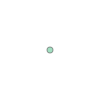

In [255]:
gdf.loc[0, 'geometry']

In [270]:
places_df = pd.concat([places_df.loc[~places_df.url.isin(gdf.url)], gdf], ignore_index=True ).drop_duplicates('url')

## Карта
На месте пустоты - кладбище

In [136]:
places_df['geometry'] = places_df.geometry.astype(str)

C:\Users\yupes\anaconda3\envs\python-gis\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [137]:
places_df.geometry = [shapely.wkt.loads(r['geometry']) for i, r in places_df.iterrows()]

<AxesSubplot:>

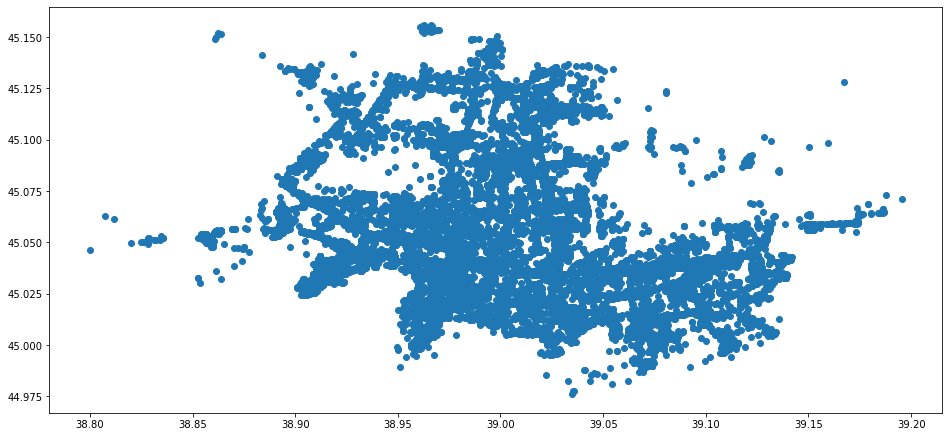

In [294]:
places_df.plot(figsize = (16, 15))

## Статистика

Топ-20 по отзывам

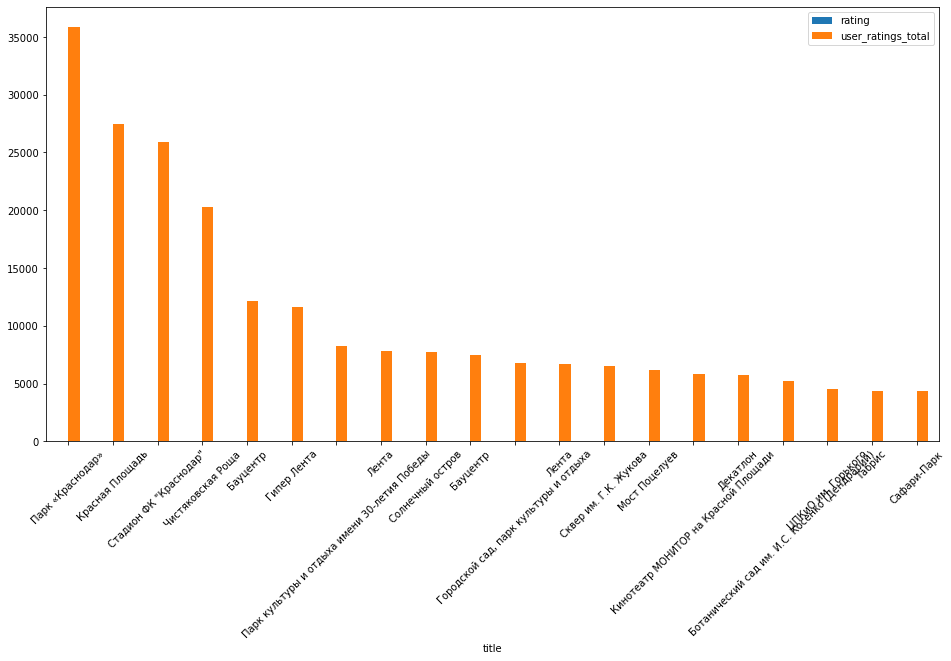

In [4]:
# ax =  places_df.sort_values('user_ratings_total', ascending = False)[:20].plot(kind = 'bar', rot = 45, x = 'title', figsize = (16, 8))


In [5]:
places_df.shape

(15527, 10)

Поиск обязательных аттракторов: 

Присутствуют:
+ Парк Краснодар (Галицкого) 	Близко к району проектирования, современный парк, - нельзя с собаками
+ Парк Солнечный остров	Требует ухода, есть пляж, проблема с вывозом мусора
+ Сафари-парк	Зоопарк на территории с солнечного острова, запущенный
+ Парк 30-летия Победы	Военный музей, набережная реки Кубань
+ Парк Рождественский	Место «пикников», неблагоустроенный 
+ Старая Кубань	Пляж, грязный, грязная река
+ Сквер Дружбы	Ухоженный сквер в центре, многолюдный
+ Ботанический сад им. профессора И. С. Косенко Ухоженный, уютный
+ Чистяковская роща	Много зелени, несколько запущенный 
+ Сквер им. Маршала Г.К. Жукова	Маленький уютный сквер, напротив администрации
- Городской сад	Исторический парк, проблемы с аттракционом
- Городской сад	Парк в начале Красной улицы, нравится горожанам
- Учебный Ботанический Сад	Иногда открыт только для экскурсий (Ботанический сад 1/ КубГУ)

In [22]:
places_df.loc[places_df.title.str.contains('Солнечный')]

,url,title,address,category,popular_times_bars,geometry,types,rating,user_ratings_total,count_photo
389,https://www.google.com/maps/place/?q=place_id:...,"Совхоз ""Солнечный"" 2-е отделение","Краснодарский край, 350012",Автобусная остановка,NaN,POINT (38.90287000000001 45.088045),"['transit_station', 'point_of_interest', 'esta...",NaN,NaN,NaN
1441,https://www.google.com/maps/place/?q=place_id:...,Солнечный сад,"ул. Новороссийская, 2а, Краснодар, Краснодарск...",Цветочный магазин,NaN,POINT (39.000688 45.022289),"['florist', 'point_of_interest', 'store', 'est...",4.7,7.0,4
2741,https://www.google.com/maps/place/?q=place_id:...,Солнечный остров,"Краснодар, Краснодарский край, 350002",Парк развлечений,"['Загруженность в 04:00: 1%.', 'Загруженность ...",POINT (39.0543808 45.0073079),"['amusement_park', 'tourist_attraction', 'poin...",4.6,7730.0,13271
7246,https://www.google.com/maps/place/?q=place_id:...,ЖК «Солнечный Парк»,"ул. имени Симиренко, 37, Краснодар, Краснодарс...",Офис компании,NaN,POINT (38.9486478 45.07223889999999),"['point_of_interest', 'establishment']",4.1,117.0,140
7872,https://www.google.com/maps/place/?q=place_id:...,Детский сад № 182 Солнечный город,"ул. Жлобы, 143, Краснодар, Краснодарский край,...",Детский сад,NaN,POINT (39.0326589 45.0468647),"['school', 'point_of_interest', 'establishment']",3.6,12.0,15
8383,https://www.google.com/maps/place/?q=place_id:...,"ООО ""Научно-Техническая компания ""Солнечный це...","ул. Атарбекова, 1/1, Краснодар, Краснодарский ...",Производитель,NaN,POINT (38.9422739 45.0602295),"['point_of_interest', 'establishment']",2.9,9.0,36
9041,https://www.google.com/maps/place/?q=place_id:...,"Краснодарский Центр Йоги Айенгара ""Солнечный""","ул. Архитектора Ишунина, д. 8/20, Краснодар, К...",Студия йоги,NaN,POINT (38.9580084 45.0660845),"['gym', 'health', 'point_of_interest', 'establ...",4.8,4.0,4
10167,https://www.google.com/maps/place/?q=place_id:...,Свх Солнечный 2ое. Отд.16,"Краснодар, Краснодарский край, 350053",Пивоварня,NaN,POINT (38.911658 45.08958800000001),"['food', 'point_of_interest', 'establishment']",5.0,1.0,NaN
10208,https://www.google.com/maps/place/?q=place_id:...,"Совхоз ""Солнечный"" 2-е отделение","Краснодар, Краснодарский край, 350012",Автобусная остановка,"['Загруженность в 04:00: 0%.', 'Загруженность ...",POINT (38.904421 45.089211),"['transit_station', 'point_of_interest', 'esta...",5.0,2.0,NaN
10770,https://www.google.com/maps/place/?q=place_id:...,Солнечный,"ул. Атарбекова, 1, Краснодар, Краснодарский кр...",Аптека,NaN,POINT (38.9557398 45.060954),"['pharmacy', 'health', 'point_of_interest', 's...",NaN,NaN,NaN
